# Greenland Ice Velocity dataset tutorial
The PROMICE Ice Velocity product is a time-series of Greenland Ice Sheet velocity mosaics based on ESA Sentinel-1 SAR offset tracking (spatial resolution: 200 m). A new mosaic spanning 2 Sentinel-1A/-1B/-1C cycles is posted every 12 days, with each new mosaic supplied as a NetCDF file. The data product is described in detail in [Solgaard et al. (2021)](https://doi.org/10.5194/essd-13-3491-2021)
We aim to make each new mosaic available within 10 days of the last included acquisition.

Here, we will look at how to load and handle a single file in the dataset, using example points and regions of interest. Specifically, we will:
1. Download a NetCDF file from the dataset hosted on the Dataverse portal
2. Visualize velocities over a defined region
3. Return the dataset values at a given point
4. Produce a velocity profile across a flowline

First, let's import all the packages we will be using.

In [5]:
# For data downloading
import requests

# For plotting
import matplotlib.pyplot as plt

# For dataset loading and handling
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree

## 1. Download the dataset from the Dataverse portal
The PROMICE Ice Velocity product is available on the [GEUS Dataverse](https://doi.org/10.22008/FK2/LFZLZN). To download the entire dataset, we can use wget through the command line:

```
$ wget -r -e robots=off -nH --cut-dirs=3 --content-disposition "https://dataverse.geus.dk/api/datasets/:persistentId/dirindex?persistentId=doi:10.22008/FK2/LFZLZN"
```

Or we can download individual files using wget in a Python console. In this example, we will download a Dataverse file from April/May 2025.

In [ ]:
# Define URL to download
URL = "https://dataverse.geus.dk/api/access/datafile/90001"

# Define file location and name
out_file = "IV_ROTR_20250422_20250516.nc"

# Start session
SESSION = requests.Session()

# Download file from URL
print(f"Downloading from {URL}...")
r = SESSION.get(URL, stream=True)
r.raise_for_status()
with open(out_file, "wb") as f:
    for chunk in r.iter_content(8192):
        f.write(chunk)
print(f"{out_file} downloaded")

We can open the file and check its contents. To open and handle the file, we will use xarray which is a Python package for handling multi-dimensional arrays.

In [75]:
# Define file location
in_file = "IV_ROTR_20250422_20250516.nc"

# Open file as xarray dataset
ds = xr.open_dataset(in_file)

# Print dataset metadata and overview of contents
print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:                                  (y: 13500, x: 7500, time: 1,
                                              bnds: 2)
Coordinates:
  * y                                        (y) float64 108kB -6.5e+05 ... -...
  * x                                        (x) float64 60kB -6.5e+05 ... 8....
  * time                                     (time) datetime64[ns] 8B 2025-05-04
Dimensions without coordinates: bnds
Data variables:
    crs                                      |S1 1B ...
    time_bnds                                (time, bnds) datetime64[ns] 16B ...
    land_ice_surface_easting_velocity        (time, y, x) float32 405MB ...
    land_ice_surface_northing_velocity       (time, y, x) float32 405MB ...
    land_ice_surface_vertical_velocity       (time, y, x) float32 405MB ...
    land_ice_surface_velocity_magnitude      (time, y, x) float32 405MB ...
    land_ice_surface_easting_velocity_std    (time, y, x) float32 405MB ...
    land_ice_surfa

## 2. Visualize velocities over a defined region
Now we have our file downloaded and checked, let's visualize the dataset over a defined region. Let's visualize the dataset over the region surrounding Sermeq Kujalleq (also known as Ilulissat Glacier or Jakobshavn Isbræ), a fast flowing outlet glacier in West Greenland.


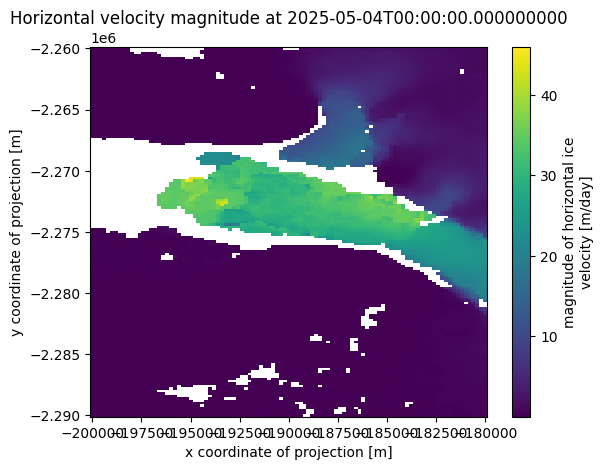

In [76]:
# Extract subset around Sermeq Kujalleq
subset = ds.sel(
    x=slice(-200000, -180000),     # lat metres (EPSG:3413)
    y=slice(-2260000, -2290000)    # lon metres (EPSG:3413)
)

# Select horizontal velocity magnitude variable
vel = subset["land_ice_surface_velocity_magnitude"]

# Plot data
plt.figure()
vel.isel(time=0).plot()
plt.title(f"Horizontal velocity magnitude at {vel.time.values[0]}")
plt.show()

We can also plot the standard deviation and other variables in the dataset. Let's print a list of the variables in the dataset and then plot the velocity magnitude error magnitude

In [77]:
# Print list of dataset variables
print(list(ds.variables))

['crs', 'y', 'x', 'time', 'time_bnds', 'land_ice_surface_easting_velocity', 'land_ice_surface_northing_velocity', 'land_ice_surface_vertical_velocity', 'land_ice_surface_velocity_magnitude', 'land_ice_surface_easting_velocity_std', 'land_ice_surface_northing_velocity_std', 'land_ice_surface_velocity_magnitude_std']


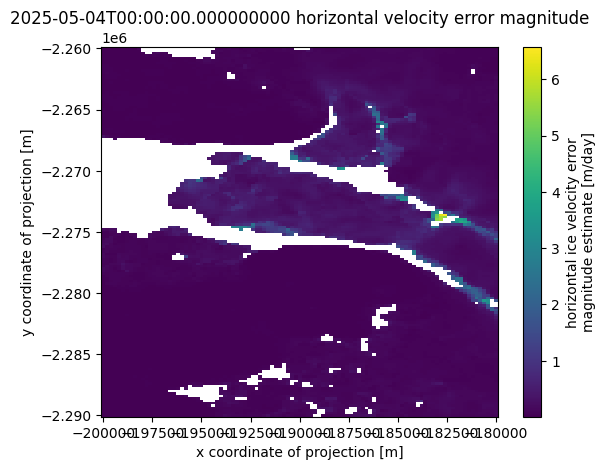

In [78]:
# Select horizontal velocity magnitude error magnitude variable
vel_std = subset["land_ice_surface_velocity_magnitude_std"]

# Plot error data
plt.figure()
vel_std.isel(time=0).plot()
plt.title(f"{vel_std.time.values[0]} horizontal velocity error magnitude")
plt.show()

## 3. Return a velocity value at a given point

We can query the dataset and return its values at a given point by providing coordinates. In this example, we will define a point on Helheim Glacier, East Greenland, and get the dataset values from the nearest grid point.

In [79]:
# Define point at Helheim Glacier
x = 302500      # lat metres (EPSG:3413)
y = -2578000    # lon metres (EPSG:3413)

# Extract nearest grid point
pt = ds.sel(
    x = x,
    y = y,
    method="nearest"
)

# Print all dataset values at point
for v in list(pt.variables):
    print(f"{v}: {pt[v].values}")

crs: b''
y: -2578000.0
x: 302600.0
time: ['2025-05-04T00:00:00.000000000']
time_bnds: [['2025-04-22T00:00:00.000000000' '2025-05-16T00:00:00.000000000']]
land_ice_surface_easting_velocity: [19.87535]
land_ice_surface_northing_velocity: [-1.7838999]
land_ice_surface_vertical_velocity: [-1.1011173]
land_ice_surface_velocity_magnitude: [19.955248]
land_ice_surface_easting_velocity_std: [0.14901774]
land_ice_surface_northing_velocity_std: [0.27570385]
land_ice_surface_velocity_magnitude_std: [0.15045358]


And then we can plot the point location over the dataset, including the velocity magnitude in the plot title.

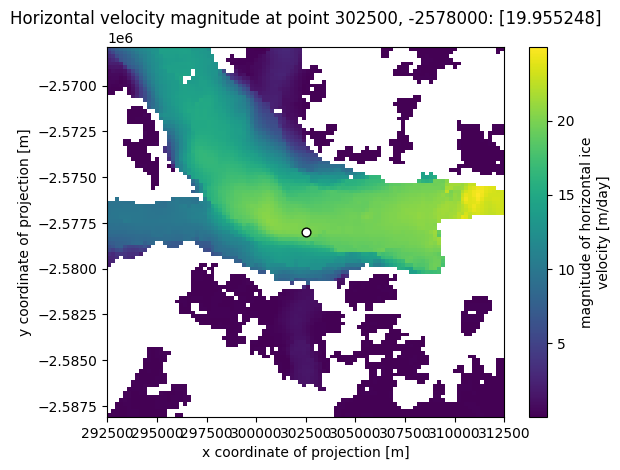

In [80]:
# Prime plotting space
plt.figure()

# Plot velocity magnitude
vel = ds["land_ice_surface_velocity_magnitude"].sel(
    x=slice(x-10000, x+10000),     # lat metres (EPSG:3413)
    y=slice(y+10000, y-10000)    # lon metres (EPSG:3413)
)
vel.isel(time=0).plot()

# Plot point
plt.scatter(x, y, c="white", s=40, marker="o", edgecolors="black")

# Construct title including velocity magnitude value
plt.title(f"Horizontal velocity magnitude at point {x}, {y}: {pt['land_ice_surface_velocity_magnitude'].values}")

# Show plot
plt.show()

## 4. Produce a velocity profile along a flowline
Now let's try to generate a velocity profile across a flowline.

This flowline should be a one-dimensional line that represents a glacier's primary path of ice flow. We will firstly make a hypothetical flowline ourselves over the catchment of Hagen Bræ in Northeast Greenland. Then we will generate a velocity profile over this flowline, plotting the distance along the flowline versus horizontal velocity magnitude.

Firstly, let's define our flowline as a set of predefined points. Then we will generate evenly spaced points along our flowline, and compute the cumulative distance along this.

In [81]:
# Define flowline point locations
flowline_x = np.array([264352, 259672, 253754, 248511, 242556, 237624, 232692])
flowline_y = np.array([-902677, -906701, -908797, -911508, -915952, -919951, -923950])

dist_flowline = np.zeros(len(flowline_x))
for i in range(1, len(flowline_x)):
    dx = flowline_x[i] - flowline_x[i-1]
    dy = flowline_y[i] - flowline_y[i-1]
    dist_flowline[i] = dist_flowline[i-1] + np.sqrt(dx**2 + dy**2)

# Number of points along flowline
n_points = 100
even_dist = np.linspace(0, dist_flowline[-1], n_points)

# Interpolate x, y at evenly spaced distances
x_even = np.interp(even_dist, dist_flowline, flowline_x)
y_even = np.interp(even_dist, dist_flowline, flowline_y)

print(x_even)
print(y_even)

[264352.         264057.26130094 263762.52260189 263467.78390283
 263173.04520377 262878.30650471 262583.56780566 262288.8291066
 261994.09040754 261699.35170848 261404.61300943 261109.87431037
 260815.13561131 260520.39691226 260225.6582132  259930.91951414
 259627.47102331 259261.06367229 258894.65632128 258528.24897027
 258161.84161925 257795.43426824 257429.02691722 257062.61956621
 256696.21221519 256329.80486418 255963.39751317 255596.99016215
 255230.58281114 254864.17546012 254497.76810911 254131.36075809
 253764.95340708 253419.03917461 253073.75644299 252728.47371137
 252383.19097976 252037.90824814 251692.62551652 251347.34278491
 251002.06005329 250656.77732167 250311.49459006 249966.21185844
 249620.92912682 249275.6463952  248930.36366359 248585.08093197
 248266.31283138 247954.78741348 247643.26199557 247331.73657767
 247020.21115976 246708.68574186 246397.16032395 246085.63490605
 245774.10948814 245462.58407023 245151.05865233 244839.53323442
 244528.00781652 244216.48

We can plot our flowline point locations over one of our velocity datasets to see where our velocities will come from.

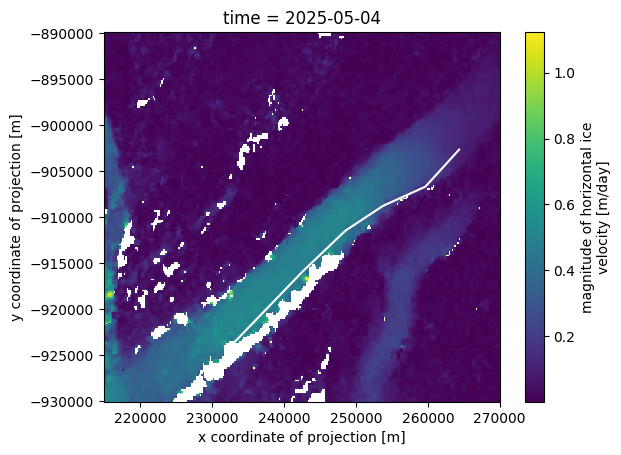

In [82]:
# Plot horizontal velocity magnitude at Hagen Bræ
subset = ds.sel(
    x=slice(215000, 270000),
    y=slice(-890000, -930000)
)
vel = subset["land_ice_surface_velocity_magnitude"]
plt.figure()
vel.isel(time=0).plot()

# Overlay point location
plt.plot(x_even, y_even, c="white")

# Show plot
plt.show()

We can now extract velocity values at the nearest grid points using a nearest neighbour search across flattened grid coordinates in our velocity dataset.

In [83]:
# Flatten grid coordinates
xx, yy = np.meshgrid(subset.x.values, subset.y.values)
x_grid = xx.ravel()
y_grid = yy.ravel()

vel_data = subset["land_ice_surface_velocity_magnitude"].isel(time=0).values.ravel()  # first time step
valid_mask = ~np.isnan(vel_data)
x_grid = x_grid[valid_mask]
y_grid = y_grid[valid_mask]
vel_data = vel_data[valid_mask]

# Use cKDTree for nearest neighbor search
tree = cKDTree(np.column_stack([x_grid, y_grid]))
dist_nn, idx_nn = tree.query(np.column_stack([x_even, y_even]))
vel_profile = vel_data[idx_nn]
print(vel_profile)

[0.10809925 0.11999231 0.12360931 0.14084172 0.14464518 0.15407673
 0.15915045 0.17393772 0.18559128 0.2013465  0.20831625 0.21608911
 0.18018158 0.17920458 0.18085794 0.10436615 0.09657082 0.18657504
 0.1397582  0.14038154 0.13451584 0.14140125 0.23614323 0.27058762
 0.2986701  0.26981676 0.24471496 0.24008055 0.24574107 0.23808864
 0.2375864  0.2492825  0.34056464 0.3400024  0.33575875 0.30199912
 0.33673346 0.37904674 0.39017016 0.38392198 0.4163811  0.44511548
 0.41966242 0.42277795 0.390115   0.39490643 0.3973016  0.44634748
 0.50034654 0.50547254 0.50981563 0.49442837 0.46980956 0.46045917
 0.47101945 0.47579578 0.50655967 0.49140102 0.50587314 0.4927576
 0.46526182 0.4740593  0.4633618  0.4846661  0.48178336 0.47709897
 0.48508802 0.49615014 0.4899684  0.4930186  0.4930323  0.49578857
 0.48693433 0.49196577 0.5052106  0.49300146 0.48009127 0.49902394
 0.5095842  0.5091545  0.4896691  0.48973712 0.5018733  0.49520224
 0.5347696  0.5201946  0.5247926  0.535591   0.5104283  0.65563

And then we can plot our velocity profile along the flowline, specifically plotting distance along the flowline versus velocity.

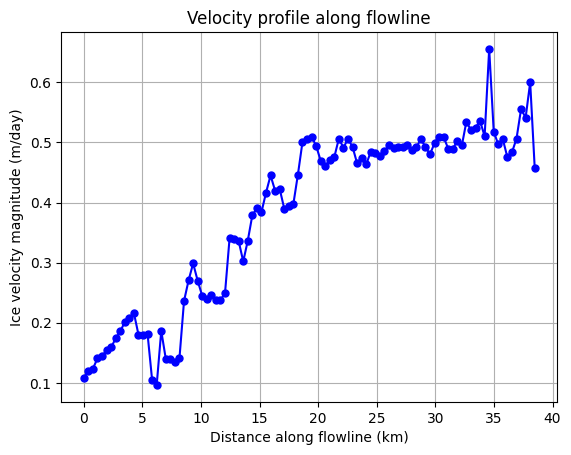

In [85]:
plt.figure()
plt.plot(even_dist/1000, vel_profile, '-o', color='blue', markersize=5)
plt.xlabel("Distance along flowline (km)")
plt.ylabel("Ice velocity magnitude (m/day)")
plt.title("Velocity profile along flowline")
plt.grid(True)
plt.show()

Plots such as these can provide insight into spatial changes in ice velocity. To examine velocity changes over time then we will need to handle and process multiple files in the Greenland Ice Velocity dataset. An overview of how to do this is provided in the next tutorial.